# Elastic field around a Griffith crack - 2D Piece-wise linear element

Plane Elastic problem

Displacements and stresses around a straight crack  $ x_1 \in [-a,a] $ under pure tensile loading $\sigma$.

We test the computation of the displacement and stress at observation points by setting the solution of the collocation BEM to the analytical solution on the BE mesh.

The crack displacement discontinuity is given by for $ x_1 \in [-a,a] $:

$\Delta u_1 (x_1,x_2=0)= u_1 (x_1,x_2=0^+)-u_1 (x_1,x_2=0^-)=0 $ 

$\Delta u_2 (x_1,x_2=0)= u_2 (x_1,x_2=0^+)-u_2 (x_1,x_2=0^-)= \frac{4 \sigma}{E^\prime} \sqrt{a^2-x_1^2} =\frac{2 (1-\nu) \sigma}{G} \sqrt{a^2-x_1^2}  $ 

where $E^\prime = E / (1-\nu^2) $ is the plane strain Young's modulus, $G = E/ (2(1+\nu)) $ the shear modulus, $E$ the Young's modulus and $\nu$ the Poisson's ratio.


In [1]:
import sys,os,time
import matplotlib.pyplot as plt

# load the analytical solution 
sys.path.append(os.path.join(os.getcwd(), '../..'))
from solutions.griffith_crack import displacement_griffith,stress_griffith,width_griffith
# %% importing BigWham 
import numpy as np

from bigwham4py import BEMatrix

In [2]:
#%% Elastic properties
G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)
Eprime = E/(1-nu**2)
# %% Mesh 
a = 1.
nelts = 101
coor1D = np.linspace(-a, a, nelts + 1)
coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)


In [3]:
kernel = "2DP1-H"
elas_prop = np.array([E, nu])
eta=3.0
max_leaf_size = 64
eps_aca = 1.0e-3
h = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca,n_openMP_threads=8)

#colpts=h.getCollocationPoints()


NUM OF OMP THREADS in BigWham: 8
 Now setting things for kernel ... 2DP1-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1.8e-05
 binary cluster tree depth =2
 Number of blocks =16
 Number of full blocks =10
 Number of low rank blocks =6
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 10 
Loop on low rank blocks construction
N low rank blocks 6
dof_dimension: 2
Creation of hmat done in 0.013834
Compression ratio - 0.684394
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 0.684394, eps_aca = 0.001, eta = 3
Hierarchical matrix  construction time = :  0.013861
--------------------


In [4]:
# x
x_obs=np.linspace(-3*a,3*a,500)
yoffset = 0.17
obs_pts = np.transpose([x_obs , x_obs*0.+yoffset])
#
u,v = displacement_griffith(x_obs+yoffset*(1j),a=a,sig=1,nu=nu,G=G)


In [5]:
# Crack opening displacement discontinuity from analytical solution 
# note that 2DP1 segment have their solution at nodes.... 
# note that 2DP1 segment have displacement disconinuity at element vertex for each element
x_coor_node = np.ones(2*nelts)
for e in range(nelts):
    x_coor_node[e*2:e*2+2]=coor1D[conn[e]]
    
w = (4*1/Eprime)*np.sqrt(a**2-x_coor_node[:]**2)   

# total dd vectors at nodes (2DP1 case)
d = np.transpose([w*0.,w])

# note the displacement kernel is not coded up yet for 2DP1   !!
# so we only check stresses....
# results from collocation BEM observation (with known solution for the relative DD)
sigma=h.compute_stresses(obs_pts,-d)   # minus sign due to convention of positive dd in overlap in the inner of Bigwham....

In [6]:
width_griffith(x_coor_node,a=a,sig=1.,nu=nu,G=G)-w

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Evolution of Stresses around a Griffith crack

In [7]:
# analytical results
s_11,s_22,s_12 = stress_griffith(x_obs+yoffset*(1j),a=a,sig=1,nu=nu)


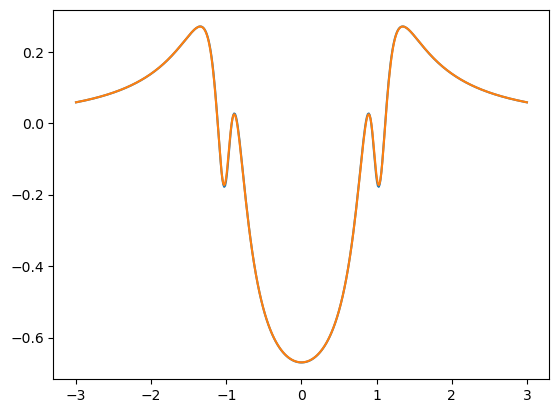

In [8]:
plt.plot(x_obs,sigma[:,0])
plt.plot(x_obs,s_11)

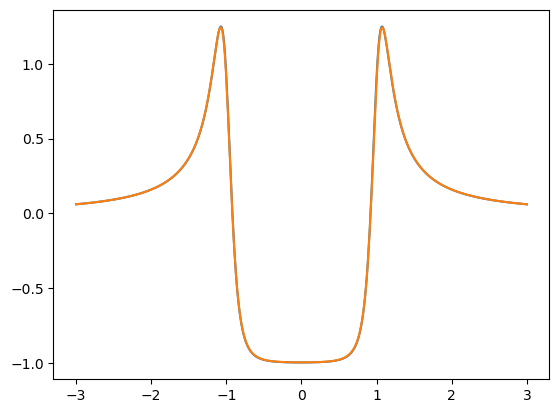

In [9]:
plt.plot(x_obs,sigma[:,1])
plt.plot(x_obs,s_22)

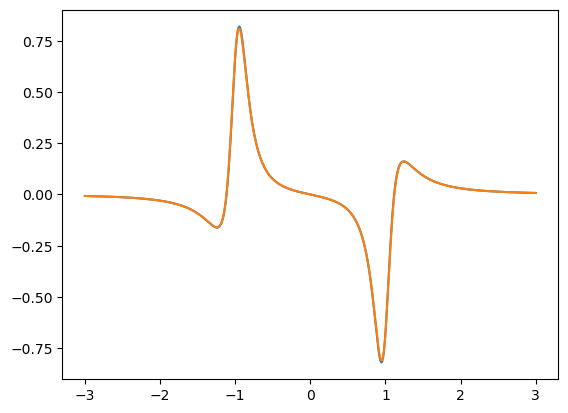

In [10]:
plt.plot(x_obs,sigma[:,2])
plt.plot(x_obs,s_12)